In [1]:
# imports and loading clean data
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

from modules.lv_utils import load_households, load_voters

# load the data
households = load_households('data_clean/20180725_fullset_households_district3.csv')
voters = load_voters('data_clean/20180725_fullset_voters_district3.csv')
elections = pd.read_csv('data_clean/20180621_election_data.csv')


Blog/article on manipulating multi_index: https://jakevdp.github.io/PythonDataScienceHandbook/03.05-hierarchical-indexing.html

In [2]:
voters.shape

(13307, 148)

In [3]:
print(voters.columns[0:75])
print(voters.columns[75:])

Index(['Vid', 'Abbr', 'Precinct', 'PrecinctSub', 'Party', 'PartyMain',
       'RegDate', 'PAV', 'RegDateOriginal', 'E6_110816', 'E5_060716',
       'E4_110414', 'E3_060314', 'E2_110612', 'E1_060512', 'District',
       'VScore', 'VScorePos', 'VScorePct', 'BirthYear',
       'OldestInHouseBirthYear', 'IsOldestInHouse', 'havePhone',
       'BirthPlaceState', 'BirthPlaceStateRegion', 'BirthPlaceCountry',
       'BirthPlaceCountryRegion', 'Gender', 'sameMailAddress', 'MailCountry',
       'isApt', 'Zip', 'StreetType', 'EmailProvider', 'E5_060716BT',
       'E1_060512BT', 'Hid', 'cHid', 'E34_nVotesPos', 'E34_nVotes',
       'E34_nVotesPct', 'E56_nVotesPos', 'E56_nVotes', 'E56_nVotesPct',
       'E78_nVotesPos', 'E78_nVotes', 'E78_nVotesPct', 'E12_nVotesPos',
       'E12_nVotes', 'E12_nVotesPct', 'E14_nVotesPos', 'E14_nVotes',
       'E14_nVotesPct', 'E16_nVotesPos', 'E16_nVotes', 'E16_nVotesPct',
       'Eap_nVotesPos', 'Eap_nVotes', 'Eap_nVotesPct', 'Eag_nVotesPos',
       'Eag_nVotes', 'E

In [4]:
#full col list
data_cols = ['Abbr', 'Precinct', 'PrecinctSub', 'Party', 'PartyMain',
       'RegDate', 'PAV', 'RegDateOriginal','VScorePct', 'nVScorePctInHH', 'BirthYear',
       'OldestInHouseBirthYear', 'IsOldestInHouse', 'havePhone',
       'BirthPlaceState', 'BirthPlaceStateRegion', 'BirthPlaceCountry',
       'BirthPlaceCountryRegion', 'Gender', 'sameMailAddress', 'MailCountry',
       'isApt', 'Zip', 'StreetType', 'EmailProvider','nVotersInHH', 'PAVCode', 'nPAVInHH',
       'HasParty', 'nAffInHH', 'isDEM', 'isREP', 'isNPP', 'nDEMInHH',
       'nREPInHH', 'nNPPInHH', 'CityArea', 'mostAfflsInHH', 'mixedAfflsInHH',
       'allAffInHH', 'uniformAffInHH']
# cut down list for checking/developing code
#data_cols = ['Party', 'PartyMain','PAV','nVotersInHH', 'PAVCode','HasParty', 'nAffInHH', 'isDEM', 'isREP',]
e_cols = ['E6_110816', 'E5_060716','E4_110414', 'E3_060314', 'E2_110612', 'E1_060512']
gdt_cols = ['E1_GndTth', 'E2_GndTth', 'E3_GndTth', 'E4_GndTth','E5_GndTth', 'E6_GndTth']
nvp_cols = ['E6_nVotesPct','E5_nVotesPct','E4_nVotesPct','E3_nVotesPct','E2_nVotesPct','E1_nVotesPct']
nvphh_cols = ['E1_nVotesPctInHH', 'E2_nVotesPctInHH', 'E3_nVotesPctInHH',
              'E4_nVotesPctInHH', 'E5_nVotesPctInHH', 'E6_nVotesPctInHH']
cv_cols = ['E34_nVotesPct', 'E56_nVotesPct', 'E78_nVotesPct']
cvhh_cols = ['E34_nVotesPctInHH','E56_nVotesPctInHH','E78_nVotesPctInHH']

#Make all series start with E1 (turn around where required:)
e_cols = e_cols[::-1]
nvp_cols = nvp_cols[::-1]

In [5]:
voters.loc[:5,cv_cols+cvhh_cols]

,E34_nVotesPct,E56_nVotesPct,E78_nVotesPct,E34_nVotesPctInHH,E56_nVotesPctInHH,E78_nVotesPctInHH
0,1.0,1.000000,1.000000,1.0,1.000000,1.000000
1,1.0,0.666667,0.800000,1.0,0.500000,0.600000
2,1.0,0.750000,0.833333,0.8,0.545455,0.705882
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000
4,-1.0,-1.000000,-1.000000,-1.0,-1.000000,-1.000000
5,-1.0,-1.000000,-1.000000,0.5,0.250000,0.333333


In [6]:
cols = e_cols+gdt_cols+nvp_cols+nvphh_cols+cv_cols+cvhh_cols
dfw = voters.loc[:,cols+data_cols]
dfw.iloc[:5,5:15]

,E6_110816,E1_GndTth,E2_GndTth,E3_GndTth,E4_GndTth,E5_GndTth,E6_GndTth,E1_nVotesPct,E2_nVotesPct,E3_nVotesPct
0,A,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,A,-1.0,1.0,0.0,1.0,1.0,1.0,-1.0,1.0,0.0
2,A,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3,N,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
4,,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [7]:
# relevant question on unstack rather than stack
#https://stackoverflow.com/questions/33057946/unstack-or-pivot-only-some-columns


In [8]:
ele = ['E1','E2','E3','E4','E5','E6','E7','E8']
dfw_data = dfw.drop(columns=cols)
dfw_data.index.rename('vid', inplace=True)

dfw_elecs = dfw[e_cols]
dfw_elecs.index.rename('vid', inplace=True)
dfw_elecs.columns = ele[:6]
dfw_elecs = dfw_elecs.join(pd.DataFrame(np.nan, index=dfw_elecs.index, columns=['E7','E8']))

dfw_gdt = dfw[gdt_cols]
dfw_gdt.index.rename('vid', inplace=True)
dfw_gdt.columns = ele[:6]

dfw_nvp = dfw[nvp_cols]
dfw_nvp.index.rename('vid', inplace=True)
dfw_nvp.columns = ele[1:7]

dfw_nvphh = dfw[nvphh_cols]
dfw_nvphh.index.rename('vid', inplace=True)
dfw_nvphh.columns = ele[1:7]

dfw_cv = dfw[list(np.repeat(cv_cols,2))]
dfw_cv.index.rename('vid', inplace=True)
dfw_cv.columns = ele[2:8]

dfw_cvhh = dfw[list(np.repeat(cvhh_cols,2))]
dfw_cvhh.index.rename('vid', inplace=True)
dfw_cvhh.columns = ele[2:8]

#display(dfw_data)
#display(dfw_elecs)
#display(dfw_gdt)
#display(dfw_nvp)

In [9]:
#pd.DataFrame(dfw_elecs.unstack(level=1).reorder_levels([1,0]))
ustk_e = pd.DataFrame(dfw_elecs.unstack(level=1))
ustk_e.columns = ['vote']
ustk_g = pd.DataFrame(dfw_gdt.unstack(level=1))
ustk_g.columns = ['gndtth']
ustk_l = pd.DataFrame(dfw_nvp.unstack(level=1))
ustk_l.columns = ['lastelec']
ustk_lhh = pd.DataFrame(dfw_nvphh.unstack(level=1))
ustk_lhh.columns = ['lastelechh']
ustk_r = pd.DataFrame(dfw_cv.unstack(level=1))
ustk_r.columns = ['lastcycle']
ustk_rhh = pd.DataFrame(dfw_cvhh.unstack(level=1))
ustk_rhh.columns = ['lastcyclehh']
#display(ustk_r)
#display(ustk_g)

# combining the various reshaped election tables and the person data
data = ustk_e.join([ustk_g, ustk_l, ustk_lhh, ustk_r, ustk_rhh]).fillna(-1)\
            .join(dfw_data).reorder_levels([1,0]).sort_index(level=0)
data.index.levels[1].name = 'e'

In [10]:
print(data.shape)
data.iloc[:16,:14]

(106456, 47)


vote  gndtth  lastelec  lastelechh  lastcycle  lastcyclehh  Abbr  \
vid e                                                                     
0   E1    V     1.0      -1.0        -1.0  -1.000000         -1.0    82   
    E2    V     1.0       1.0         1.0  -1.000000         -1.0    82   
    E3    V     1.0       1.0         1.0   1.000000          1.0    82   
    E4    V     1.0       1.0         1.0   1.000000          1.0    82   
    E5    A     1.0       1.0         1.0   1.000000          1.0    82   
    E6    A     1.0       1.0         1.0   1.000000          1.0    82   
    E7   -1    -1.0       1.0         1.0   1.000000          1.0    82   
    E8   -1    -1.0      -1.0        -1.0   1.000000          1.0    82   
1   E1         -1.0      -1.0        -1.0  -1.000000         -1.0    82   
    E2    V     1.0      -1.0        -1.0  -1.000000         -1.0    82   
    E3    N     0.0       1.0         1.0   1.000000          1.0    82   
    E4    V     1.0       0.0         0.0   1.000000          1.0    82   
    E5    A     1.0       1.0         0.5   0.666667          0.5    82   
    E6    A     1.0       1.0         0.5   0.666667          0.5    82   
    E7   -1    -1.0       1.0         0.8   0.800000          0.6    82   
    E8   -1    -1.0      -1.0        -1.0   0.800000          0.6    82   

        Precinct  PrecinctSub Party PartyMain    RegDate PAV RegDateOriginal  
vid e                                                                         
0   E1    832400            0   DEM       DEM 1992-10-05   Y      1992-10-05  
    E2    832400            0   DEM       DEM 1992-10-05   Y      1992-10-05  
    E3    832400            0   DEM       DEM 1992-10-05   Y      1992-10-05  
    E4    832400            0   DEM       DEM 1992-10-05   Y      1992-10-05  
    E5    832400            0   DEM       DEM 1992-10-05   Y      1992-10-05  
    E6    832400            0   DEM       DEM 1992-10-05   Y      1992-10-05  
    E7    832400            0   DEM       DEM 1992-10-05   Y      1992-10-05  
    E8    832400            0   DEM       DEM 1992-10-05   Y      1992-10-05  
1   E1    832910            0   DEM       DEM 2012-11-06   Y      2012-10-26  
    E2    832910            0   DEM       DEM 2012-11-06   Y      2012-10-26  
    E3    832910            0   DEM       DEM 2012-11-06   Y      2012-10-26  
    E4    832910            0   DEM       DEM 2012-11-06   Y      2012-10-26  
    E5    832910            0   DEM       DEM 2012-11-06   Y      2012-10-26  
    E6    832910            0   DEM       DEM 2012-11-06   Y      2012-10-26  
    E7    832910            0   DEM       DEM 2012-11-06   Y      2012-10-26  
    E8    832910            0   DEM       DEM 2012-11-06   Y      2012-10-26

In [11]:
elections.index = ele[::-1]
elections.index.name = 'e'
elections

,elections,dates,cycle,etype,president,us_senate_maj,us_repre_maj,ca_governor,ca_lt_govnor,ca_senate_maj,ca_assembly_maj
e,,,,,,,,,,,
E8,E8_110618,2018-11-06,Cong,General,REP,4,42,DEM,DEM,-13,-28
E7,E7_060518,2018-06-05,Cong,Primary,REP,4,42,DEM,DEM,-13,-28
E6,E6_110816,2016-11-08,Pres,General,DEM,10,60,DEM,DEM,-13,-24
E5,E5_060716,2016-06-07,Pres,Primary,DEM,10,58,DEM,DEM,-13,-24
E4,E4_110414,2014-11-04,Cong,General,DEM,-8,34,DEM,DEM,-13,-31
E3,E3_060314,2014-06-03,Cong,Primary,DEM,-8,34,DEM,DEM,-13,-31
E2,E2_110612,2012-11-06,Pres,General,DEM,-3,50,DEM,DEM,-11,-25
E1,E1_060512,2012-06-05,Pres,Primary,DEM,-3,52,DEM,DEM,-11,-25


In [12]:
data = data.join(elections)
data = data.drop(columns=['elections','dates'])  # duplicated information

In [13]:
print(data.shape)
data.iloc[:16,:5+50:]

(106456, 56)


vote  gndtth  lastelec  lastelechh  lastcycle  lastcyclehh  Abbr  \
vid e                                                                     
0   E1    V     1.0      -1.0        -1.0  -1.000000         -1.0    82   
    E2    V     1.0       1.0         1.0  -1.000000         -1.0    82   
    E3    V     1.0       1.0         1.0   1.000000          1.0    82   
    E4    V     1.0       1.0         1.0   1.000000          1.0    82   
    E5    A     1.0       1.0         1.0   1.000000          1.0    82   
    E6    A     1.0       1.0         1.0   1.000000          1.0    82   
    E7   -1    -1.0       1.0         1.0   1.000000          1.0    82   
    E8   -1    -1.0      -1.0        -1.0   1.000000          1.0    82   
1   E1         -1.0      -1.0        -1.0  -1.000000         -1.0    82   
    E2    V     1.0      -1.0        -1.0  -1.000000         -1.0    82   
    E3    N     0.0       1.0         1.0   1.000000          1.0    82   
    E4    V     1.0       0.0         0.0   1.000000          1.0    82   
    E5    A     1.0       1.0         0.5   0.666667          0.5    82   
    E6    A     1.0       1.0         0.5   0.666667          0.5    82   
    E7   -1    -1.0       1.0         0.8   0.800000          0.6    82   
    E8   -1    -1.0      -1.0        -1.0   0.800000          0.6    82   

        Precinct  PrecinctSub Party      ...       allAffInHH uniformAffInHH  \
vid e                                    ...                                   
0   E1    832400            0   DEM      ...            False          False   
    E2    832400            0   DEM      ...            False          False   
    E3    832400            0   DEM      ...            False          False   
    E4    832400            0   DEM      ...            False          False   
    E5    832400            0   DEM      ...            False          False   
    E6    832400            0   DEM      ...            False          False   
    E7    832400            0   DEM      ...            False          False   
    E8    832400            0   DEM      ...            False          False   
1   E1    832910            0   DEM      ...            False          False   
    E2    832910            0   DEM      ...            False          False   
    E3    832910            0   DEM      ...            False          False   
    E4    832910            0   DEM      ...            False          False   
    E5    832910            0   DEM      ...            False          False   
    E6    832910            0   DEM      ...            False          False   
    E7    832910            0   DEM      ...            False          False   
    E8    832910            0   DEM      ...            False          False   

       cycle    etype  president  us_senate_maj  us_repre_maj  ca_governor  \
vid e                                                                        
0   E1  Pres  Primary        DEM             -3            52          DEM   
    E2  Pres  General        DEM             -3            50          DEM   
    E3  Cong  Primary        DEM             -8            34          DEM   
    E4  Cong  General        DEM             -8            34          DEM   
    E5  Pres  Primary        DEM             10            58          DEM   
    E6  Pres  General        DEM             10            60          DEM   
    E7  Cong  Primary        REP              4            42          DEM   
    E8  Cong  General        REP              4            42          DEM   
1   E1  Pres  Primary        DEM             -3            52          DEM   
    E2  Pres  General        DEM             -3            50          DEM   
    E3  Cong  Primary        DEM             -8            34          DEM   
    E4  Cong  General        DEM             -8            34          DEM   
    E5  Pres  Primary        DEM             10            58          DEM   
    E6  Pres  General        DEM             

In [14]:
data = data.reset_index()
#data.info()

In [15]:
obj = data.select_dtypes(include=object)
obj.describe()

,e,vote,PartyMain,BirthPlaceStateRegion,BirthPlaceCountryRegion,EmailProvider,CityArea,mostAfflsInHH,cycle,etype,president,ca_governor,ca_lt_govnor
count,106456,106456,106456,106456,106456,106456,106456,106456,106456,106456,106456,106456,106456
unique,8,5,5,5,7,202,3,18,2,2,2,1,1
top,E1,N,DEM,UNK,USA,UNK,Centerville,DEM,Pres,General,DEM,DEM,DEM
freq,13307,30329,53072,50912,56592,72072,73496,60544,53228,53228,79842,106456,106456


# Explore the data for corelations

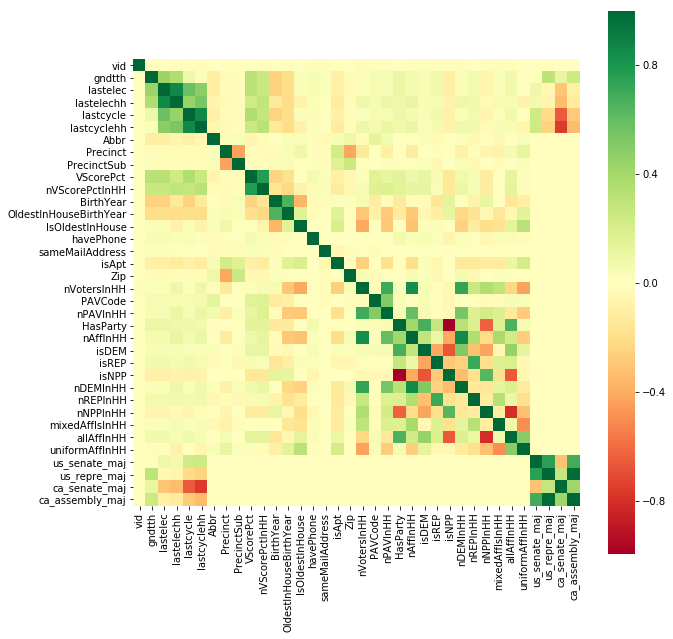

In [16]:
plt.rcParams["figure.figsize"] = (10,10)

# explore the data with a heat map
sns.heatmap(data.corr(), square=True, cmap='RdYlGn')
plt.show()

# First trying Random Forest Model

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [18]:
#df = data[data.e.isin(['E1','E2','E3','E4','E5','E6'])] #- accuracy dropped - even with imputed -1 for missing data
df = data[data.e.isin(['E3','E4','E5','E6'])]

In [19]:
# looking at how balanced our classes are:
print(df.vote.value_counts())
print(df.gndtth.value_counts())

N    21970
A    14146
     10071
V     7041
Name: vote, dtype: int64
 0.0    21970
 1.0    21187
-1.0    10071
Name: gndtth, dtype: int64


In [20]:
# need variance check - then drop 'ca_governor', 'ca_lt_govnor' 
# as column is same across data therefore carries no information
df = df.drop(columns=['ca_governor', 'ca_lt_govnor'])

In [21]:
# Object and category columns for get_dummies
print(df.select_dtypes(exclude=["number","bool_", "datetime"]).columns)
# Datetime columns for removal
print(df.select_dtypes(exclude=["number","bool_", "object_", "category"]).columns)

Index(['e', 'vote', 'Party', 'PartyMain', 'PAV', 'BirthPlaceState',
       'BirthPlaceStateRegion', 'BirthPlaceCountry', 'BirthPlaceCountryRegion',
       'Gender', 'MailCountry', 'StreetType', 'EmailProvider', 'CityArea',
       'mostAfflsInHH', 'cycle', 'etype', 'president'],
      dtype='object')
Index(['RegDate', 'RegDateOriginal'], dtype='object')


In [22]:
df_d = pd.get_dummies(data=df, columns=['Party', 'PartyMain', 'PAV', 'BirthPlaceState',
       'BirthPlaceStateRegion', 'BirthPlaceCountry', 'BirthPlaceCountryRegion',
       'Gender', 'MailCountry', 'StreetType', 'EmailProvider', 'CityArea',
       'mostAfflsInHH', 'cycle', 'etype', 'president'])
df_d = df_d.drop(columns=['RegDate', 'RegDateOriginal'])

In [23]:
X = df_d.drop(columns=['vid','vote','e','gndtth'])
y = df_d.gndtth

In [24]:
# Split the data into a training and test set.
X, Xtest, y, ytest = train_test_split(X, y, shuffle=True, random_state=5)

In [25]:
model = RandomForestClassifier()
model = model.fit(X,y)

In [26]:
print(accuracy_score(ytest, model.predict(Xtest)))

0.8898324190275795


After adding impution to -1 for the lastelection and last cycle columns I ran the modeling with all Elections E1-E6.
the accuracy dropped

In [27]:
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(15)

,importance
VScorePct,0.168328
lastelec,0.106859
lastcycle,0.074836
nVScorePctInHH,0.072252
lastcyclehh,0.059446
Abbr,0.040553
etype_General,0.031232
lastelechh,0.030745
us_repre_maj,0.030398
BirthYear,0.028139


In [28]:
# removing my friends engineered features and running the model again
X = df_d.drop(columns=['vid','vote','e','gndtth', 'VScorePct', 'nVScorePctInHH'])
y = df_d.gndtth
X, Xtest, y, ytest = train_test_split(X, y, shuffle=True, random_state=5)
model = RandomForestClassifier()
model = model.fit(X,y)
print(accuracy_score(ytest, model.predict(Xtest)))

0.7690689110994213


## Tuning the Random Forest
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [29]:
# Resetting the data
X = df_d.drop(columns=['vid','vote','e','gndtth'])
y = df_d.gndtth
# Split the data into a training and test set.
X, Xtest, y, ytest = train_test_split(X, y, shuffle=True, random_state=5)

In [30]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 800, stop = 2000, num = 7)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 60, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
display(random_grid)

{'n_estimators': [800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [31]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
#from sklearn.ensemble import RandomForestRegressor - Regressor is for continous problems
#rf = RandomForestRegressor()
rf =  RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total= 2.7min
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, total= 3.0min
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, boot

[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True, total= 4.3min


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 37.4min


[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=False, total= 5.6min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True, total= 1.8min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True, total= 1.8min
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True, total= 4.3min
[CV] n_estima

[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total= 2.8min
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total= 2.9min
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, total= 1.4min
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total= 1.6min
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=800,

[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total= 1.9min
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True, total= 3.1min
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total= 1.9min
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total= 1.9min
[CV] n_estimators=1600, min_sa

[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total= 1.7min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total= 1.7min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False, total= 4.8min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False, total= 4.8min
[CV] n_estimators

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 134.5min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=2)

In [32]:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

## Trying a second Logistic Regression Model

In [33]:
# Resetting the data
X = df_d.drop(columns=['vid','vote','e','gndtth'])
y = df_d.gndtth
# Split the data into a training and test set.
X, Xtest, y, ytest = train_test_split(X, y, shuffle=True, random_state=5)

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
model2 = LogisticRegression()
model2 = model2.fit(X,y)

In [36]:
print(accuracy_score(ytest, model2.predict(Xtest)))

0.486210265273916


### Tuning the Logistic Regresion model with Cross Validation

In [37]:
from sklearn.model_selection import cross_val_score

clf = LogisticRegression()

#cv_results = cross_val_score(clf, X, y, cv=KFold(5, random_state=42))
cv_results = cross_val_score(clf, X, y, cv=5)   # if you don't need to pass the random_state
print(cv_results)
np.mean(cv_results)

[0.49380088 0.48265498 0.47401378 0.48997996 0.49486344]


0.48706260664466267

### Tuning the Logistic Regression model with a Grid Search on C

In [38]:
#the grid of parameters to search over
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for c in Cs:
    lgrg = LogisticRegression(C=c, random_state=20)
    score = cross_val_score(lgrg, X, y, cv=3)
    print('Regularization parameter c: {} had average score: {}'.format(c, score))
# your turn

Regularization parameter c: 0.0001 had average score: [0.4912083  0.50522282 0.49879753]
Regularization parameter c: 0.001 had average score: [0.4912083  0.50514767 0.49879753]
Regularization parameter c: 0.01 had average score: [0.4912083  0.50514767 0.49879753]
Regularization parameter c: 0.1 had average score: [0.4912083  0.50928083 0.49879753]
Regularization parameter c: 1 had average score: [0.4912083  0.50514767 0.49879753]
Regularization parameter c: 10 had average score: [0.4912083  0.50514767 0.49879753]
Regularization parameter c: 100 had average score: [0.4912083  0.50514767 0.49879753]
Regularization parameter c: 1000 had average score: [0.4912083  0.50514767 0.49879753]


In [39]:
from sklearn.model_selection import GridSearchCV
# trying some different CV levels
for cv in [3,5,7,10]:
    print("Trying {} folds".format(cv))
    parameters = {'C':Cs}
    gslr = LogisticRegression(random_state=20)
    gsclf = GridSearchCV(gslr, parameters, cv=cv)
    gsclf.fit(X, y)
    print("Best parameter: {}".format(gsclf.best_params_))
    print("Best score: {}".format(gsclf.best_score_))
    print("Test set accuracy: {}".format(accuracy_score(ytest,gsclf.predict(Xtest))))

Trying 3 folds
Best parameter: {'C': 0.1}
Best score: 0.49976203000926833
Test set accuracy: 0.486210265273916
Trying 5 folds
Best parameter: {'C': 0.0001}
Best score: 0.4870619473460084
Test set accuracy: 0.486210265273916
Trying 7 folds
Best parameter: {'C': 0.0001}
Best score: 0.49127025876105307
Test set accuracy: 0.486210265273916
Trying 10 folds
Best parameter: {'C': 0.0001}
Best score: 0.4957040154304752
Test set accuracy: 0.486210265273916


Check: number of votes cast - so total number of N's vs total number of A,V's - to identify what % prediction a nieve model would give.

Check/play with tuning parameters - vs Default, grid searching for best value in Random Forest, tree size and feature depth - revise options, for Log Regression different paramters

check for overfitting - how - increase randomness factor

which feature most important particularly Random Forest - validate no data leakage

Sort NaNs imputing to -1 for RF
consider binning for LR - one bin for less than 0, one for 0-.3333, 0.333-.6666, .666 -1

Try working through SciKit-Learn Exploration using regression for prediction  - plotting ROC curves for the LR model to optimize it.

# Returning to Random Forest and exploring optimizting
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

In [40]:
# Resetting the data
X = df_d.drop(columns=['vid','vote','e','gndtth'])
y = df_d.gndtth
# Split the data into a training and test set.
X, Xtest, y, ytest = train_test_split(X, y, shuffle=True, random_state=5)

In [41]:
model = RandomForestClassifier()
model = model.fit(X,y)
print(accuracy_score(ytest, model.predict(Xtest)))

0.8938152851882468


In [42]:
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [43]:
y_pred = model.predict(Xtest)

In [44]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(ytest, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

ValueError: Data is not binary and pos_label is not specified